In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [2]:
# vehicle assignment function
def veh_type_simulator(n_truck, vehicle_type_fraction): # Simulate mode choice
    choice = np.random.multinomial(n_truck, vehicle_type_fraction, size = 1)
    choice = pd.Series(choice[0])
#     print(choice)
    return(choice)

def split_dataframe(df, chunk_size = 100000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [3]:
scenario_name = 'TDA_low'
firms = read_csv('outputs_aus_2040/forecast_firms_with_fleet_' + scenario_name + '.csv')
private_fleet = read_csv('inputs/fleet/TX_private_fleet_size_distribution_V2.csv')
for_hire_fleet = read_csv('inputs/fleet/TX_for_hire_fleet_size_distribution_V2.csv')
for_lease_fleet = read_csv('inputs/fleet/TX_for_lease_fleet_size_distribution_V2.csv')
cargo_type_distribution = read_csv("inputs/fleet/probability_of_cargo_group.csv")

# forecast values
national_fleet_composition = read_csv('inputs/fleet/' + scenario_name + '/TDA_vehicle_stock.csv')
vehicle_type_by_state = read_csv('inputs/fleet/' + scenario_name + '/fleet_composition_by_state.csv')
ev_fraction = read_csv('inputs/fleet/' + scenario_name + '/EV_fraction_by_type.csv')

state_fips_lookup = read_csv('inputs/us-state-ansi-fips.csv')
# vehicle_type_fraction = [0.206287,	0.505178, 0.244464, 0.044071]  # will be replaced once input from Alicia is ready

In [4]:
# filter vehicle composition data
analysis_year = 2040
vehicle_type_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Year'] == analysis_year]

national_fleet_composition = \
national_fleet_composition.loc[national_fleet_composition['Year'] == analysis_year]

ev_fraction = ev_fraction.loc[ev_fraction['Year'] == analysis_year]

vehicle_type_by_state.head(5)

,Year,state,Service type,vehicle type,fuel type,vehicle category,veh_fraction
66,2040,ALABAMA,FOR HIRE,Class 4-6 Vocational,Diesel,Diesel Class 4-6 Vocational,6.402684e-02
67,2040,ALABAMA,FOR HIRE,Class 4-6 Vocational,Electric,Electric Class 4-6 Vocational,3.305617e-04
68,2040,ALABAMA,FOR HIRE,Class 4-6 Vocational,Gasoline,Gasoline Class 4-6 Vocational,3.069915e-02
143,2040,ALABAMA,FOR HIRE,Class 7&8 Tractor,Diesel,Diesel Class 7&8 Tractor,8.076622e-01
144,2040,ALABAMA,FOR HIRE,Class 7&8 Tractor,Electric,Electric Class 7&8 Tractor,7.663253e-07


In [5]:
# load b2b output
combined_b2b_flow = None
for i in range(5):
    sctg = i + 1
    sctg_code = 'sctg' + str(sctg)
    file_dir = 'outputs_aus_2040/' + sctg_code + '_truck/'
    filelist = [file for file in os.listdir(file_dir) if (file.endswith('.csv'))]
    print(sctg_code)
    combined_csv = pd.concat([read_csv(file_dir + f, low_memory=False) for f in filelist ])
    combined_csv = combined_csv.loc[combined_csv['mode_choice'] == 'Private Truck']
    combined_b2b_flow = pd.concat([combined_b2b_flow, combined_csv])
#     break
combined_b2b_flow.head(5)

sctg1
sctg2
sctg3
sctg4
sctg5


,BuyerID,BuyerZone,BuyerNAICS,SellerID,SellerZone,SellerNAICS,TruckLoad,SCTG_Group,shipment_id,orig_FAFID,dest_FAFID,mode_choice,probability,Distance,Travel_time
0,497722,569,230301,123194,3304,212310.0,35.538047,1,9000001,489,488,Private Truck,0.135821,274.23,20.218923
30,497722,569,230301,123194,3304,212310.0,35.538047,1,9000034,489,488,Private Truck,0.135821,274.23,20.218923
31,497722,569,230301,123194,3304,212310.0,35.538047,1,9000035,489,488,Private Truck,0.135821,274.23,20.218923
48,497722,569,230301,123194,3304,212310.0,35.538047,1,9000053,489,488,Private Truck,0.135821,274.23,20.218923
58,497722,569,230301,123194,3304,212310.0,35.538047,1,9000063,489,488,Private Truck,0.135821,274.23,20.218923


<AxesSubplot:>

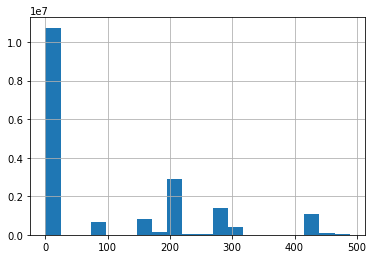

In [6]:
combined_b2b_flow.Distance.hist(bins = 20)

In [7]:
# select firms with private truck shipment
selected_firms_with_load = combined_b2b_flow.groupby(['SellerID'])[['TruckLoad']].sum()
selected_firms_with_load = selected_firms_with_load.reset_index()
selected_firms_with_load.columns = ['BusID', 'Production']
print(len(selected_firms_with_load))
selected_firms_with_load.head(5)

9010


,BusID,Production
0,1015,59077.095319
1,1079,122536.179831
2,2408,32946.704554
3,2414,69896.873678
4,2417,331.641000


In [8]:
# separate firms with/without private truck shipment
print(len(firms))
selected_sellers = selected_firms_with_load.BusID.unique()
firms_without_adj = firms.loc[~firms['BusID'].isin(selected_sellers)]
firms_with_adj = pd.merge(firms, selected_firms_with_load,
                          on = 'BusID', how = 'inner')
print(len(firms_without_adj))
print(len(firms_with_adj))
firms_with_adj.head(5)

8279833
8262647
17186


,Unnamed: 0,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any),Production
0,25,48375,489,1,31161A,5,0.002975,862487,4793,35.20701,...,TEXAS,0,0,0,0,0,0,0,PHEV,29.864500
1,26,115,487,1,325414,21,0.003012,8397073,20115,27.78629,...,TEXAS,0,0,0,0,0,0,0,PHEV,5376.707293
2,221910,76,350,1,112A00,1,1.000000,8397073,20076,36.30340,...,NEW MEXICO,0,0,0,0,0,0,0,PHEV,5376.707293
3,224618,48,221,1,1111B0,2,1.000000,8397073,20048,30.18335,...,LOUISIANA,0,0,0,0,0,0,0,PHEV,5376.707293
4,224658,43,202,1,1121A0,1,1.000000,8397073,20043,37.60966,...,KANSAS,0,0,0,0,0,0,0,PHEV,5376.707293


In [9]:
# format fleet composition
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()

private_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'PRIVATE']
private_fleet_by_state_wide = pd.pivot_table(private_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
private_fleet_by_state_wide = private_fleet_by_state_wide.reset_index()


for_hire_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'FOR HIRE']
for_hire_fleet_by_state_wide = pd.pivot_table(for_hire_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_hire_fleet_by_state_wide = for_hire_fleet_by_state_wide.reset_index()


for_lease_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'LEASE']
for_lease_fleet_by_state_wide = pd.pivot_table(for_lease_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_lease_fleet_by_state_wide = for_lease_fleet_by_state_wide.reset_index()

private_fleet_by_state_wide.head(5)

vehicle category,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,ALABAMA,0.278063,0.303801,0.281457,0.001436,2.882522e-07,0.001371,0.133323
1,ALASKA,0.315013,0.221711,0.308352,0.001626,2.103636e-07,0.001502,0.151040
2,ARIZONA,0.314028,0.308356,0.223576,0.001621,2.925744e-07,0.001089,0.150568
3,ARKANSAS,0.181140,0.538998,0.190556,0.000935,5.114112e-07,0.000928,0.086852
4,CALIFORNIA,0.319376,0.327610,0.196774,0.001649,3.108428e-07,0.000958,0.153132


In [10]:
print(firms_with_adj.columns)
firms_with_adj = firms_with_adj[['Unnamed: 0', 'esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'Production']]

Index(['Unnamed: 0', 'CBPZONE', 'FAFZONE', 'esizecat', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'n_trucks',
       'st', 'stname', 'stusps', 'state', 'Diesel Class 4-6 Vocational',
       'Diesel Class 7&8 Tractor', 'Diesel Class 7&8 Vocational',
       'Electric Class 4-6 Vocational', 'Electric Class 7&8 Tractor',
       'Electric Class 7&8 Vocational', 'Gasoline Class 4-6 Vocational',
       'EV_powertrain (if any)', 'Production'],
      dtype='object')


17186


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std,n_trucks
0,0-2,0,0.709745,1.218434,0.413643,1
0,0-2,0,0.709745,1.218434,0.413643,1
0,0-2,0,0.709745,1.218434,0.413643,1
3,11-50,11,0.057430,20.340672,9.548775,26
0,0-2,0,0.709745,1.218434,0.413643,1


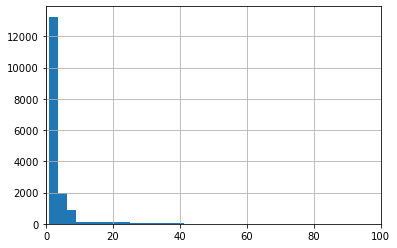

In [11]:
# re-generate fleet size for selected firms
sample_size = len(firms_with_adj)
# print(tx_private_fleet.columns)
private_fleet_short = private_fleet[['fleet_size', 'min_size', 
                                    'fraction_of_carrier', 
                                    'avg_truck_per_carrier', 
                                    'total_truck_std']]

firm_fleet_sample = \
private_fleet_short.sample(n = sample_size,
                           weights = private_fleet_short['fraction_of_carrier'],
                           replace = True)
print(len(firm_fleet_sample))
# generate random fleet size
firm_fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = firm_fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = firm_fleet_sample.loc[:, 'total_truck_std'])
criteria = (firm_fleet_sample['n_trucks'] <= 1)
firm_fleet_sample.loc[criteria, 'n_trucks'] = 1
firm_fleet_sample.loc[:, 'n_trucks'] = np.round(firm_fleet_sample.loc[:, 'n_trucks'], 0)
firm_fleet_sample.loc[:, 'n_trucks'] = firm_fleet_sample.loc[:, 'n_trucks'].astype(int)

firm_fleet_sample['n_trucks'].hist(bins = 1000)
plt.xlim([0,100])
firm_fleet_sample.head(5)

In [12]:
# append vehicle composition to firms by state
firm_fleet_sample = firm_fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
firms_with_adj = firms_with_adj.sort_values(by = ['Production'], ascending = True)

firm_fleet_sample_short = firm_fleet_sample[['n_trucks']]

firms_with_fleet = pd.concat([firms_with_adj.reset_index(drop=True), 
                              firm_fleet_sample_short.reset_index(drop=True)], axis=1)

firms_with_fleet.loc[:, 'FAFZONE'] = firms_with_fleet.loc[:,'FAFZONE'].astype(str).str.zfill(3)
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'FAFZONE'].str[:2]
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'st'].astype(int)

firms_with_fleet = pd.merge(firms_with_fleet, state_fips_lookup,
                            on = 'st', how = 'left')

firms_with_fleet.loc[:,'stname'] = firms_with_fleet.loc[:,'stname'].str.upper()

firms_with_fleet = pd.merge(firms_with_fleet, private_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

firms_with_fleet.head(5)

,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,75968,1,48347,489,424700,17,0.500000,1474574,4632,31.70441,...,TEXAS,TX,TEXAS,0.218955,0.482842,0.190969,0.00113,4.581297e-07,0.00093,0.104983
1,2996212,1,48005,489,424700,17,3.666667,1473399,96,31.30524,...,TEXAS,TX,TEXAS,0.218955,0.482842,0.190969,0.00113,4.581297e-07,0.00093,0.104983
2,76088,1,48149,489,424700,17,0.500000,1472274,2671,29.90038,...,TEXAS,TX,TEXAS,0.218955,0.482842,0.190969,0.00113,4.581297e-07,0.00093,0.104983
3,2883148,1,114,486,424700,18,3.600259,1474694,20114,30.19437,...,TEXAS,TX,TEXAS,0.218955,0.482842,0.190969,0.00113,4.581297e-07,0.00093,0.104983
4,354395,2,48183,489,424700,18,1.070545,1475392,2841,32.53689,...,TEXAS,TX,TEXAS,0.218955,0.482842,0.190969,0.00113,4.581297e-07,0.00093,0.104983


In [13]:
# assign vehicle technology
chunks = split_dataframe(firms_with_fleet)
i = 0
for chunk in chunks:
    print('processing chunk ' + str(i))
    chunk[list_of_veh_tech] = \
    chunk.apply(
            lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
    # print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
    if i==0:
        firms_with_fleet = chunk
    else:
        firms_with_fleet = pd.concat([firms_with_fleet, chunk])
    i += 1
firms_with_fleet.head(5)

processing chunk 0


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,75968,1,48347,489,424700,17,0.500000,1474574,4632,31.70441,...,TEXAS,TX,TEXAS,0,0,1,0,0,0,0
1,2996212,1,48005,489,424700,17,3.666667,1473399,96,31.30524,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
2,76088,1,48149,489,424700,17,0.500000,1472274,2671,29.90038,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
3,2883148,1,114,486,424700,18,3.600259,1474694,20114,30.19437,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
4,354395,2,48183,489,424700,18,1.070545,1475392,2841,32.53689,...,TEXAS,TX,TEXAS,0,0,1,0,0,0,0


In [14]:
# assign EV type
# print(ev_fraction)

# carriers_with_fleet.loc[:, 'n_trucks'] = carriers_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)
# leasing_with_fleet.loc[:, 'n_trucks'] = leasing_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)

powertrain = ev_fraction.Powertrain.to_numpy()
print(powertrain)
probability = ev_fraction.EV_fraction.to_numpy()

sample_size = len(firms_with_fleet)
firms_with_fleet.loc[:, 'EV_powertrain (if any)'] = \
pd.Series(np.random.choice(powertrain, size = sample_size, p=probability) ) 

firms_with_fleet.head(5)

['Battery Electric' 'H2 Fuel Cell' 'PHEV Diesel' 'PHEV Gasoline']


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,75968,1,48347,489,424700,17,0.500000,1474574,4632,31.70441,...,TX,TEXAS,0,0,1,0,0,0,0,PHEV Diesel
1,2996212,1,48005,489,424700,17,3.666667,1473399,96,31.30524,...,TX,TEXAS,0,1,0,0,0,0,0,PHEV Diesel
2,76088,1,48149,489,424700,17,0.500000,1472274,2671,29.90038,...,TX,TEXAS,0,1,0,0,0,0,0,PHEV Gasoline
3,2883148,1,114,486,424700,18,3.600259,1474694,20114,30.19437,...,TX,TEXAS,0,1,0,0,0,0,0,PHEV Diesel
4,354395,2,48183,489,424700,18,1.070545,1475392,2841,32.53689,...,TX,TEXAS,0,0,1,0,0,0,0,PHEV Diesel


In [15]:
firms_with_fleet.loc[firms_with_fleet['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'

In [16]:
firms_with_fleet = firms_with_fleet.drop(columns=['Unnamed: 0', 'Production'])
firms_without_adj = firms_without_adj.drop(columns=['Unnamed: 0'])
firms_output = pd.concat([firms_without_adj, firms_with_fleet])
print(len(firms_output))
firms_output.head(5)

8279833


,CBPZONE,FAFZONE,esizecat,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,56,251,1,52A000,0,0.000635,3151496,20056,41.72200,-71.05057,...,MA,MASSACHUSETTS,0,0,0,0,0,0,0,PHEV
1,29,132,1,336411,37,0.001221,1099966,20029,31.74833,-81.85786,...,GA,GEORGIA,0,0,0,0,0,0,0,PHEV
2,41,190,1,335222,34,0.001437,1088473,20041,43.17093,-94.09719,...,IA,IOWA,0,0,0,0,0,0,0,PHEV
3,22,111,1,522A00,0,0.001840,3184608,20022,38.88843,-76.92417,...,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0,PHEV
4,22,111,1,522A00,0,0.001840,3184607,20022,38.97950,-77.04579,...,DC,DISTRICT OF COLUMBIA,0,0,0,0,0,0,0,PHEV


In [ ]:
# writing output
firms_output.to_csv('outputs_aus_2040/forecast_firms_with_fleet_'+ scenario_name + '_mc_adjusted.csv')